# Simulating Quantum Circuit using TensorFlow Quantum

Making a quantum circuit can be time-consuming, especially if too many qubits are involved, and the circuit is lengthy. To avoid the laborious process of building the circuits, we can use machine learning to design a machine learning model for such quantum circuits. Here we use Tensor flow quantum to simulate a custom quantum circuit that consists of several quantum gates.

The circuit consists of a Toffoli gate, an X gate, two CNOT gates, and five wires.

In this tutorial, we'll focus on the following steps:
- Setup
- Data
- Model
- Compiling and Fitting
- Analysis
- References

##  1 SETUP 

In [ ]:
! pip install tensorflow==2.7.0

### 1. 1 Install TensorFlow Quantum:


In [ ]:
! pip install tensorflow-quantum==0.7.2

### 1.2 Now import TensorFlow and the module dependencies:

In [18]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 2 Data

### 2.1 Classical data creation


At first, we create classical data by initializing binary numbers of 5 digits. Since we are creating a quantum circuit using five wires, we can apply the equivalent classical gates to the binary numbers.

For instance TOFFOLI can be also described as mapping bits {a, b, c} to {a, b, c XOR (a AND b)} and CNOT can be described as mapping bits {a,b} to {a XOR b} and X gate can be expressed as mapping {a} to{NOT a}

So the measure of the wire four can be equivalently expressed as ¬(e ⊕ (a ∧ b)) ⊕ d ⊕ c		

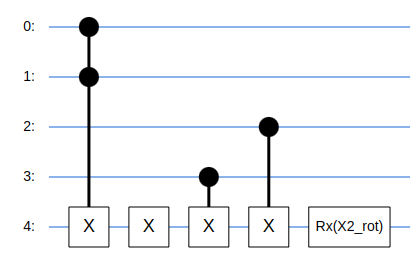

Create a  NumPy array with the required dimensions. Here we work with sizes (32,6). Here we are dealing with five wires to create 2^5 =32 rows and 6 columns. The 6th column is for the result of the operation. We consider all 32 combinations.
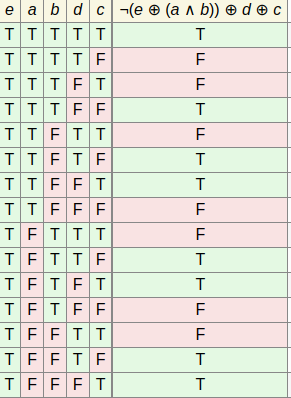

In [5]:
arr = np.zeros((32, 6))
n = 5
for i in range(32):
    b = bin(i)[2:].zfill(n)
    a =  [int(a) for a in str(b)]
    res = ((1-(a[4]^(a[0] & a[1])))^a[3])^a[2]
    a.append(res)
    for k in range(len(a)):
        arr[i][k] = int(a[k]) 

### 2.2 Encoding classical data to quantum data
There are advanced ways to encode classical data into quantum data like basis embedding, amplitude embedding, and Qsample Encoding, which are the optimal encoding methods but are pretty complex. Here we keep the encoding process simple by a more straightforward computational basis encoding which takes the binary for each qubit and flips it by applying the X gate. We use the cirq, the built-in tensor flow quantum library, natively supported in all TFQ operations. For instance, for binary 00001,
```
    cir = cirq.Circuit()
    cir.append([cirq.I(qubits[0])])
    cir.append([cirq.I(qubits[1])])
    cir.append([cirq.I(qubits[2])])
    cir.append([cirq.I(qubits[3])])
    cir.append([cirq.X(qubits[4])])
```
Among the 32 combination we use first 16 as training set and the next 16 as the testing set and if the output is 0 then we label it as -1 and if the output is 1 then we label it as 1. It is labelled as so for the hinge loss, which we will use for training.

In [6]:
def make_data(qubits):
    train, train_label = [], []
    test,test_label = [], []
    row, col = arr.shape
    
    for i in range(0,15):
        cir = cirq.Circuit()
        for j in range(0,col-1):
            cir.append([cirq.I(qubits[j])]) if arr[i][j] ==0 else cir.append([cirq.X(qubits[j])])
        train.append(cir)
        train_label.append(-1) if arr[i][j+1]==0 else train_label.append(1)
        j=0
    for i in range(15,32):
        cir = cirq.Circuit()
        for j in range(0,col-1):
            cir.append([cirq.I(qubits[j])]) if arr[i][j] ==0 else cir.append([cirq.X(qubits[j])])
        test.append(cir)
        test_label.append(-1) if arr[i][j+1]==0 else test_label.append(1)
        j=0
    return tfq.convert_to_tensor(train), np.array(train_label), tfq.convert_to_tensor(train), np.array(train_label)

## 3 Model

### 3.1 Creating the circuit

We create the circuit using cirq and sympy, which we want to model for simulation. This circuit consists of 5 quantum gates, accepts a list of qubits, and returns the circuit according to the qubits.<br>
The configuration and sequence gates are as follows:
<br><br>
<table>
  <tr>
    <th>Sequence</th>
    <th>Gate</th>
    <th>Control</th>
    <th>Target</th>
  </tr>
  <tr>
    <td>1</td>
    <td>Toffoli</td>
    <td>0,1</td>
    <td>4</td>
  </tr>
   <tr>
    <td>2</td>
    <td>X</td>
    <td>-</td>
    <td>4</td>
  </tr>
   <tr>
    <td>2</td>
    <td>CNOT</td>
    <td>3</td>
    <td>4</td>
  </tr>
   <tr>
    <td>3</td>
    <td>CNOT</td>
    <td>2</td>
    <td>4</td>
  </tr>
   <tr>
    <td>4</td>
    <td>RX</td>
    <td>-</td>
    <td>4</td>
  </tr>
</table>
<br>
The final RX rotation is arbitrary and is placed there for parametrization purposes only. The rotation gate also serves the function of reducing superposition in the input quantum data so that we can extract as much valuable information from the measurement as possible [2].

While adding the TOFFOLI gate, we could not directly add the TOFFOLI gate, which requires three qubits, due to the limitation of Tensor Flow Quantum, which can only accept particular gates for serialization as of now. This is an open issue for now [3].
The following gates are supported as of now.
```
[cirq.X, cirq.XX, cirq.Y, cirq.YY, cirq.Z, cirq.ZZ, cirq.H, cirq.CZ, cirq.CNOT, cirq.SWAP, cirq.ISWAP, cirq.PhasedXPowGate(phase_exponent=0.123), cirq.PhasedISwapPowGate(phase_exponent=0.123), cirq.FSimGate(theta=0.123, phi=0.456), cirq.I]
```


So we used the subgate as CNOT with controls 1.

In [7]:
def make_circuit(qubits):
    x2 = sympy.symbols('X2_rot')
    c = cirq.Circuit(cirq.ControlledGate(sub_gate=cirq.CNOT, num_controls=1).on(qubits[0],qubits[1],qubits[4]))
    c.append([cirq.X(qubits[4])])
    c.append(cirq.CNOT(qubits[3],qubits[4]))
    c.append(cirq.CNOT(qubits[2],qubits[4]))
    c.append(cirq.rx(x2).on(qubits[4]))
    return c

### 3.2 Initializing the qubits

Using the cirq line qubits and line, we now initialize the qubits. Integer coordinate 'x,' the only feature a qubit has, identifies the position of the qubit on the line. Here we initialize five qubits as we have five wires long circuit, then we test the circuit by making a trial circuit and printing it using cirq library's SVGCircuit.

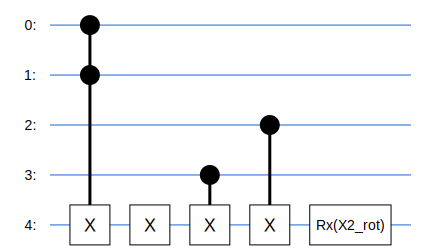

In [35]:
qubits = [cirq.LineQubit(i) for i in range(5)]
trial_circuit = make_circuit(qubits)
SVGCircuit(trial_circuit)

In [9]:
train, train_label, test, test_label = make_data(qubits)

### 3.3 Operators and inputs

To extract information from our circuit, we must apply measurement operators. We decide to undertake a Z measurement since the Pauli Z matrix establishes the framework for the measurement. Similar to a computational basis measurement, a Pauli Z basis measurement projects the state onto one of the states |0⟩ or |1⟩. 
<br> <br>
To observe an output, we must also feed our model quantum data, the line qubits we initialized. 
<br> <br>
We are using standard Keras input with type string.

In [10]:
measurement_operators = [cirq.Z(qubits[4])]
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

### 3.4 Using the PQC Layer

For training parameterized quantum models, we use PQC layer. This layer initializes the parameters and manages them in a Keras native manner given a parameterized circuit [2]. The TFQ PQC layer requires the following attributes.
```
tfq.layers.PQC(
    model_circuit,
    operators,
    *,
    repetitions=None,
    backend='noiseless',
    differentiator=None,
    initializer=tf.keras.initializers.RandomUniform(0, 2 * np.pi),
    regularizer=None,
    constraint=None,
    **kwargs
)
```
We supply our circuit created with cirq and the Pauli'Z as measurement operator. Due to the probabilistic nature of measurement, the number of repetitions introduces variation between the two rows of data. We need a differentiator to define algorithms for computing the gradients of your circuits, and we use the ParameterShift as it is a promising approach to evaluating gradients of parameterized
quantum circuits on quantum hardware [1]. Finally, we use the initializer Keras zeros initializer.


In [11]:
layer1 = tfq.layers.PQC(make_circuit(qubits), measurement_operators, repetitions = 32, differentiator=tfq.differentiators.ParameterShift(), initializer=tf.keras.initializers.Zeros)(inputs)

In [12]:
model = tf.keras.models.Model(inputs=inputs, outputs=layer1)

## 4 Compiling and Fitting

### 4.1 Compiling the model

Now we compile the model with Adam optimizer, learning rate of 0.003 and hinge loss as it is convex and is suitable for classification of data. The learning rate was picked on the basis best performance during multiple experiment. For accuracy we use the deafult tensorflow keras accuracy.

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.003), loss=tf.keras.losses.hinge, metrics=[tf.keras.metrics.Accuracy()])

/home/yudeep/anaconda3/envs/quantum/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 4.2 Fitting

We fit the model using the train and test data with a epochs of 512 and batch size of 4. We are choosing the batch size of 4 and epoch of 512 as  too large of a batch size will lead to poor generalization as our data is limited.

In [14]:
history = model.fit(train, train_label, epochs=512, batch_size=4, validation_data=(test, test_label))

Epoch 1/512
4/4 [==============================] - 1s 36ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.0000 - val_accuracy: 0.0000e+00
Epoch 2/512
4/4 [==============================] - 0s 7ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.0000 - val_accuracy: 0.0000e+00
Epoch 3/512
4/4 [==============================] - 0s 7ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.0000 - val_accuracy: 0.0000e+00
Epoch 4/512
4/4 [==============================] - 0s 7ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.0000 - val_accuracy: 0.0000e+00
Epoch 5/512
4/4 [==============================] - 0s 7ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.0000 - val_accuracy: 0.0000e+00
Epoch 6/512
4/4 [==============================] - 0s 7ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.0000 - val_accuracy: 0.0000e+00
Epoch 7/512
4/4 [==============================] - 0s 7ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.00

4/4 [==============================] - 0s 7ms/step - loss: 0.6792 - accuracy: 0.0000e+00 - val_loss: 0.6583 - val_accuracy: 0.0000e+00
Epoch 112/512
4/4 [==============================] - 0s 7ms/step - loss: 0.6458 - accuracy: 0.0000e+00 - val_loss: 0.6958 - val_accuracy: 0.0000e+00
Epoch 113/512
4/4 [==============================] - 0s 7ms/step - loss: 0.6083 - accuracy: 0.0000e+00 - val_loss: 0.6375 - val_accuracy: 0.0000e+00
Epoch 114/512
4/4 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.0000e+00 - val_loss: 0.6583 - val_accuracy: 0.0000e+00
Epoch 115/512
4/4 [==============================] - 0s 7ms/step - loss: 0.6958 - accuracy: 0.0000e+00 - val_loss: 0.6875 - val_accuracy: 0.0000e+00
Epoch 116/512
4/4 [==============================] - 0s 7ms/step - loss: 0.6583 - accuracy: 0.0000e+00 - val_loss: 0.5625 - val_accuracy: 0.0000e+00
Epoch 117/512
4/4 [==============================] - 0s 7ms/step - loss: 0.6208 - accuracy: 0.0000e+00 - val_loss: 0.662

Epoch 224/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0208 - accuracy: 0.8000 - val_loss: 0.0167 - val_accuracy: 0.8000
Epoch 225/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0250 - accuracy: 0.6667 - val_loss: 0.0292 - val_accuracy: 0.5333
Epoch 226/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0125 - accuracy: 0.8000 - val_loss: 0.0417 - val_accuracy: 0.6000
Epoch 227/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0333 - accuracy: 0.6667 - val_loss: 0.0208 - val_accuracy: 0.6667
Epoch 228/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0292 - accuracy: 0.6000 - val_loss: 0.0125 - val_accuracy: 0.8000
Epoch 229/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0250 - accuracy: 0.6667 - val_loss: 0.0125 - val_accuracy: 0.8000
Epoch 230/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0333 - accuracy: 0.6000 - val_loss: 0.0250 - val_accuracy: 0.6667
Epoch 231/512

4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 337/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 338/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 339/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 340/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 341/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 342/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.000

4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 447/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 448/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 449/512
4/4 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 450/512
4/4 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 451/512
4/4 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 452/512
4/4 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.000

4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 502/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 503/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 504/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 505/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 506/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 507/512
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.000

## 5 Analysis

As we can see, our model worked reasonably well in this situation. After the first 50 epochs, the loss significantly dropped up to 300 epochs, after which the loss reached its minimum and became constant. Both the training loss and the validation loss follow the same pattern.

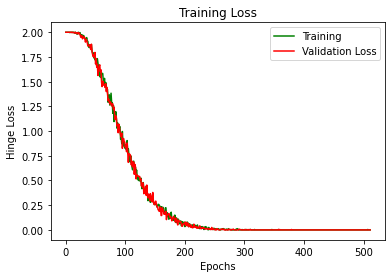

In [33]:
plt.plot(history.history['loss'], label='Training',color='green')
plt.plot(history.history['val_loss'], label='Validation Loss',color = 'red')
plt.legend()
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Hinge Loss")
plt.show()

The accuracy is similar to the loss in that it is zero for the first 150 epochs, in this case, suggesting that the model did not pick up much information during these early epochs. But after then, accuracy increased significantly, reaching its peak in about 300 epochs. Both the training and testing data show the same trend, but the testing data is slightly more reliable in the last few epochs.

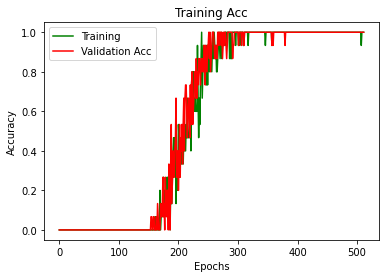

In [34]:
plt.plot(history.history['accuracy'], label='Training',color='green')
plt.plot(history.history['val_accuracy'], label='Validation Acc',color='red')
plt.legend()
plt.title("Training Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

## 6 References

1. Crooks, Gavin. (2019). Gradients of parameterized quantum gates using the parameter-shift rule and gate decomposition. 
<br>

2. Broughton, Michael & Verdon, Guillaume & McCourt, Trevor & Martinez, Antonio & Yoo, Jae & Isakov, Sergei & Massey, Philip & Niu, Yuezhen & Halavati, Ramin & Peters, Evan & Leib, Martin & Skolik, Andrea & Streif, Michael & Von Dollen, David & Mcclean, Jarrod & Boixo, Sergio & Bacon, Dave & Ho, Alan & Neven, Hartmut & Mohseni, M.. (2020). TensorFlow Quantum: A Software Framework for Quantum Machine Learning. 
<br>

3. Tensorflow. “Adds Support for CCZ and CCX/TOF Gates. by Michaelbroughton · Pull Request #487 · TENSORFLOW/Quantum.” GitHub, https://github.com/tensorflow/quantum/pull/487. 